In [2]:
#Libraries
push!(LOAD_PATH, "/home/jberez/Projects/BostonHousing/docker-parallel3")
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using JLD
using Serialization
using StatsBase
using BNN

include("utils.jl");
include("LoadData.jl");

In [3]:
#Load Boston Housing Data

dx, dy, x_train, x_test, y_train, y_test = load_data(23);

In [4]:
#folder = "/Data/BostonLong/"
#folder = "/Data/BostonFour/"
folder = "/Data/BostonTwo/"
traces = []
tests = [i for i=1:16]
#filename_pre = "trace"
filename_pre = "B2trace"
filename_end = "output.jld"

good_traces = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

for i in good_traces
    current_file = join([pwd(),folder,filename_pre,"$(tests[i])", filename_end])
    current_traces = deserialize(current_file)
    push!(traces,current_traces)
end;
chains = length(traces);

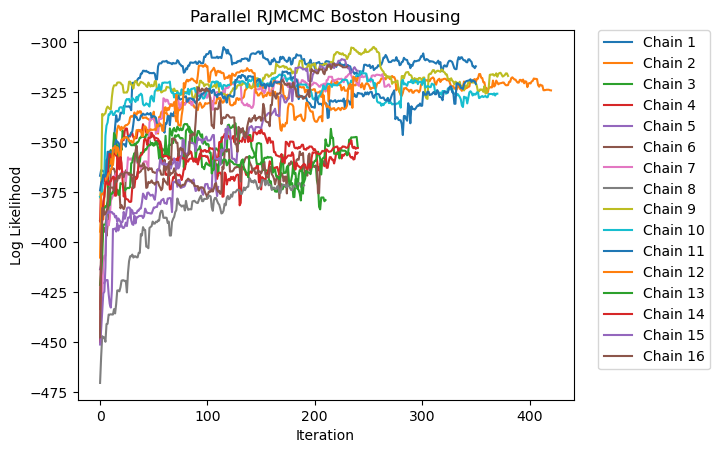

In [5]:
#Plot Log Posterior for Each Chain

for i=1:chains
    scores = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        scores[j] = get_score(trace)
    end
    plot(scores,label="Chain $i")
end
plt.title("Parallel RJMCMC Boston Housing")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood");
#plt.ylim(-500,-100)

legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

In [6]:
for i=1:chains
    println("Chain $(good_traces[i]) iterations: $(length(traces[i]))")
end

Chain 1 iterations: 351
Chain 2 iterations: 421
Chain 3 iterations: 211
Chain 4 iterations: 241
Chain 5 iterations: 111
Chain 6 iterations: 211
Chain 7 iterations: 271
Chain 8 iterations: 191
Chain 9 iterations: 381
Chain 10 iterations: 371
Chain 11 iterations: 351
Chain 12 iterations: 241
Chain 13 iterations: 241
Chain 14 iterations: 241
Chain 15 iterations: 241
Chain 16 iterations: 231


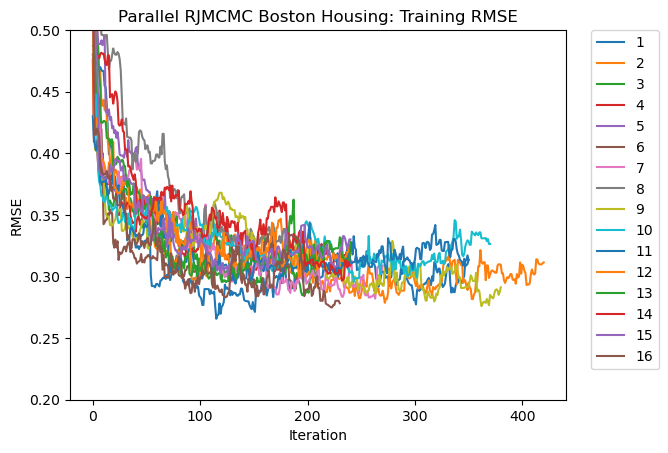

In [7]:
#Plot Train RMSE for Each Chain

for i=1:chains
    rmses = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        pred_y = transpose(G(x_train,trace))[:,1]
        rmses[j] = mse_scaled(pred_y,y_train)
    end
    plot(rmses, label="$i")
end
plt.title("Parallel RJMCMC Boston Housing: Training RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.ylim(0.2,0.5)
legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

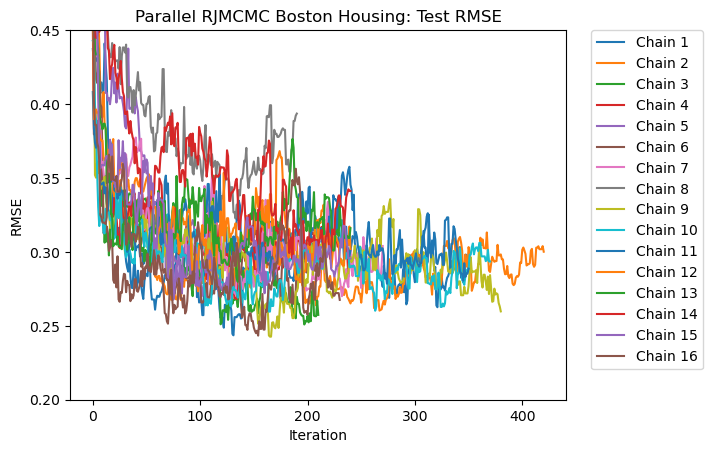

In [8]:
#Plot Test RMSE for Each Chain

for i=1:chains
    rmses = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        pred_y = transpose(G(x_test,trace))[:,1]
        rmses[j] = mse_scaled(pred_y,y_test)
    end
    plot(rmses,label="Chain $i")
end
plt.title("Parallel RJMCMC Boston Housing: Test RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.ylim(0.20,0.45)
legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

In [9]:
#Marginalize RMSE

j = 100

y_marginal = zeros(length(y_train))
number_traces = 0
total_mse = 0
for i=1:chains
    traces2 = traces[i]
    for k=j:length(traces2)
        trace = traces2[k]
        pred_y = transpose(G(x_train,trace))[:,1]
        y_marginal += pred_y
        new_mse = mse_scaled(pred_y, y_train)
        total_mse += new_mse
        number_traces += 1
    end
end
y_marginal = y_marginal ./ number_traces
mse = mse_scaled(y_marginal, y_train)
#println(total_mse / number_traces)

println("Training Set Marginal RMSE: $mse")

y_marginal = zeros(length(y_test))
pred_ys = []
number_traces = 0
total_mse = 0
for i=1:chains
    traces2 = traces[i]
    for k=j:length(traces2)
        trace = traces2[k]
        pred_y = transpose(G(x_test,trace))[:,1]
        push!(pred_ys,pred_y)
        new_mse = mse_scaled(pred_y, y_test)
        total_mse += new_mse
        y_marginal += pred_y
        number_traces += 1
    end
end
y_marginal = y_marginal ./ number_traces
mse = mse_scaled(y_marginal, y_test)
#println(total_mse / number_traces)

println("Test Set Marginal RMSE: $mse")
#println(number_traces)

Training Set Marginal RMSE: 0.2631167625458825
Test Set Marginal RMSE: 0.23963243250641958


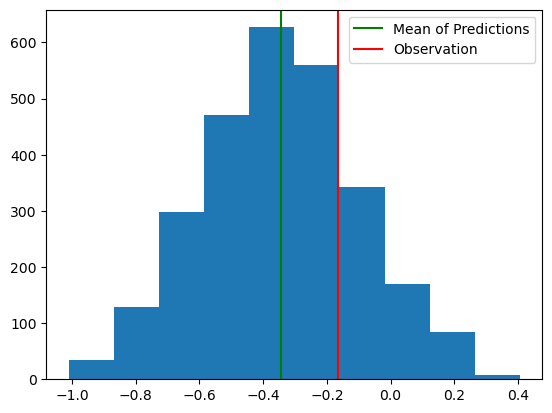

PyObject <matplotlib.legend.Legend object at 0x7f3bcac92490>

In [10]:
test_iter = 131
predictions = [preds[test_iter] for preds in pred_ys]
hist(predictions)
plt.axvline(mean(predictions),c="green",label="Mean of Predictions")
plt.axvline(y_test[test_iter],c="red",label="Observation")
plt.legend()

0.24329789623857492


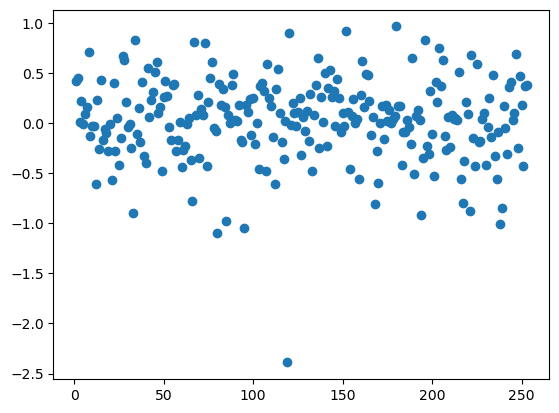

80
95
119
238


In [11]:
medians = zeros(length(y_test))
for v=1:length(y_test)
    test_iter = v
    set = [pred_ys[i][test_iter] for i=1:length(pred_ys)]
    #hist(set)
    #plt.axvline(y_test[test_iter])
    medians[v] = median(set)
end

mse = mse_scaled(medians,y_test)
println(mse)
#scatter([i for i=1:length(y_test)],medians .- y_test)
scatter([i for i=1:length(y_test)],y_marginal .- y_test)
difference = y_marginal .- y_test
for i=1:length(y_test)
    if abs(difference[i]) > 1.0
        println(i)
    end
end


In [12]:
#Marginalize all RMSEs

j = 1



for i=1:chains
    count = 0
    traces2 = traces[i]
    y_marginal = zeros(length(y_train))
    for v=j:length(traces2)
        trace = traces2[v]
        pred_y = transpose(G(x_train,trace))[:,1]
        y_marginal += pred_y
        count += 1
    end
    y_marginal = y_marginal ./count#(length(traces2)-(j-1))
    mse = mse_scaled(y_marginal, y_train)
    println("Chain $(good_traces[i]) Training Set Marginal RMSE: $(round(mse,digits=3))")
end

rmses = []
for i=1:chains
    count = 0
    traces2 = traces[i]
    y_marginal = zeros(length(y_train))
    for v=j:length(traces2)
        trace = traces2[v]
        pred_y = transpose(G(x_test,trace))[:,1]
        y_marginal += pred_y
        count += 1
    end
    y_marginal = y_marginal ./count#(length(traces2)-(j-1))
    mse = mse_scaled(y_marginal, y_test)
    println("Chain $(good_traces[i]) Test Set Marginal RMSE: $(round(mse,digits=3))")
end

Chain 1 Training Set Marginal RMSE: 0.269
Chain 2 Training Set Marginal RMSE: 0.276
Chain 3 Training Set Marginal RMSE: 0.297
Chain 4 Training Set Marginal RMSE: 0.299
Chain 5 Training Set Marginal RMSE: 0.334
Chain 6 Training Set Marginal RMSE: 0.289
Chain 7 Training Set Marginal RMSE: 0.282
Chain 8 Training Set Marginal RMSE: 0.324
Chain 9 Training Set Marginal RMSE: 0.271
Chain 10 Training Set Marginal RMSE: 0.292
Chain 11 Training Set Marginal RMSE: 0.289
Chain 12 Training Set Marginal RMSE: 0.296
Chain 13 Training Set Marginal RMSE: 0.293
Chain 14 Training Set Marginal RMSE: 0.316
Chain 15 Training Set Marginal RMSE: 0.289
Chain 16 Training Set Marginal RMSE: 0.277
Chain 1 Test Set Marginal RMSE: 0.252
Chain 2 Test Set Marginal RMSE: 0.247
Chain 3 Test Set Marginal RMSE: 0.256
Chain 4 Test Set Marginal RMSE: 0.275
Chain 5 Test Set Marginal RMSE: 0.304
Chain 6 Test Set Marginal RMSE: 0.257
Chain 7 Test Set Marginal RMSE: 0.261
Chain 8 Test Set Marginal RMSE: 0.328
Chain 9 Test Set 

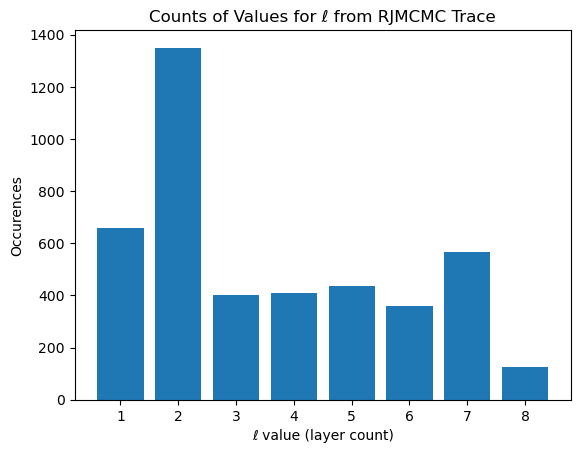

In [17]:
#Bar Plot of l estimates
l_list = [1,2,3,4,5,6,7,8]

ls = [[traces[i][j][:l] for j=1:length(traces[i])] for i=1:chains]
ls = collect(Iterators.flatten(ls))

counts = [sum([l_list[ls[i]] == j for i in 1:length(ls)]) for j in l_list]
bar(l_list,counts)

plt.title("Counts of Values for ℓ from RJMCMC Trace")
plt.xlabel("ℓ value (layer count)")
plt.ylabel("Occurences");

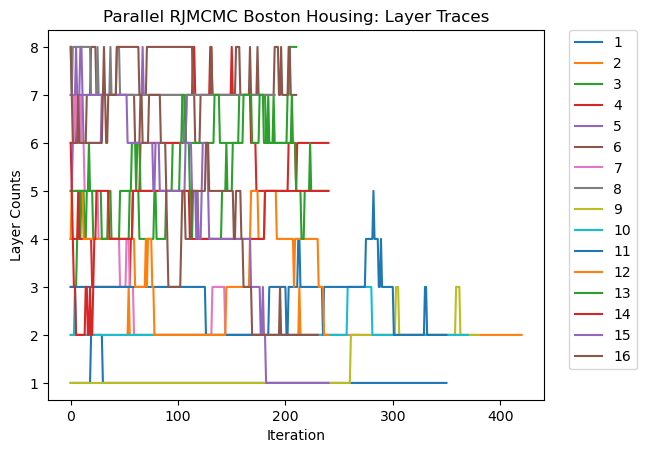

In [18]:
#Trace Plot for l
#Plot Train RMSE for Each Chain

for i=1:16
    chain_ls = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        chain_ls[j] = trace[:l]
    end
    plot(chain_ls, label="$i")
end
plt.title("Parallel RJMCMC Boston Housing: Layer Traces")
plt.xlabel("Iteration")
plt.ylabel("Layer Counts")
legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

In [19]:
#Acceptance Probability
#folder = "/Data/BostonLong/"
folder = "/Data/BostonFour/"
#folder = "/Data/BostonTwo/"

filename_pre = "B4"
filename_endA = "AcceptanceA.jld"
filename_endW = "AcceptanceW.jld"

current_file = join([pwd(),folder,filename_pre,filename_endA])
across = deserialize(current_file)
current_file = join([pwd(),folder,filename_pre,filename_endW])
within = deserialize(current_file)

across_accs = [sum(i)/length(i) for i in across]
across_total = sum(collect(Iterators.flatten(across)))/length(collect(Iterators.flatten(across)))

within_accs = [sum(i)/length(i) for i in within]
within_total = sum(collect(Iterators.flatten(within)))/length(collect(Iterators.flatten(within)))
println("Across Acceptance: $across_total")
println("Within Acceptance: $within_total")

#length(across[1])
#sum(across[1])
#edited = (sum(collect(Iterators.flatten(across)))-5)/(length(collect(Iterators.flatten(across)))-541)

Across Acceptance: 0.0113125
Within Acceptance: 0.8845


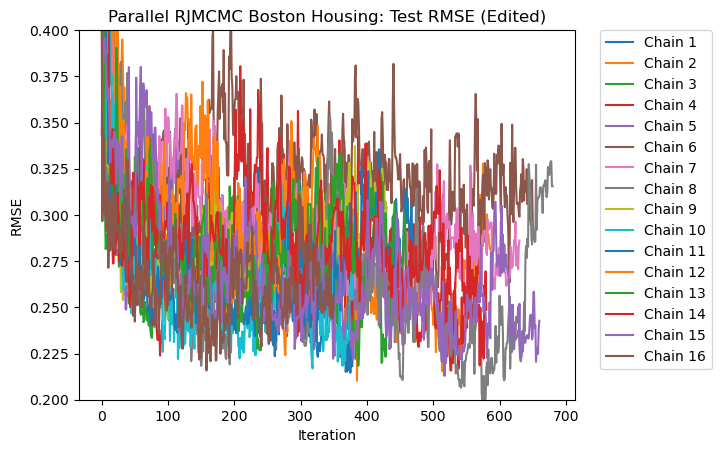

In [16]:
#Remove Outliers
y_new = [y_test[i] for i in 1:length(y_test)]
y_new = filter(x->x < 2.0,y_new)
x_subset = [(y_test[i] < 2.0 ? i : 0) for i in 1:length(y_test)]
x_subset = filter(x->x != 0,x_subset)
x_new = x_test[:,x_subset];

#Plot Test RMSE for Each Chain - No Outliers

for i=1:chains
    rmses = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        pred_y = transpose(G(x_new,trace))[:,1]
        rmses[j] = mse_scaled(pred_y,y_new)
    end
    plot(rmses,label="Chain $i")
end
plt.title("Parallel RJMCMC Boston Housing: Test RMSE (Edited)")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);
plt.ylim(0.2,0.4);

In [ ]:
#hist(y_test)
hist(y_train);
plt.title("Scaled Train Data: Median Housing Price y")
plt.xlabel("Scaled Response (y)")
plt.ylabel("Frequency");

In [18]:
#Outlier Free RMSE

#Marginalize RMSE

j = 150

y_marginal = zeros(length(y_train))
number_traces = 0
total_mse = 0
for i=1:chains
    traces2 = traces[i]
    for k=j:length(traces2)
        trace = traces2[k]
        pred_y = transpose(G(x_train,trace))[:,1]
        y_marginal += pred_y
        new_mse = mse_scaled(pred_y, y_train)
        total_mse += new_mse
        number_traces += 1
    end
end
y_marginal = y_marginal ./ number_traces
mse = mse_scaled(y_marginal, y_train)
#println(total_mse / number_traces)

println("Training Set Marginal RMSE: $mse")

y_marginal = zeros(length(y_new))
number_traces = 0
total_mse = 0
for i=1:chains
    traces2 = traces[i]
    for k=j:length(traces2)
        trace = traces2[k]
        pred_y = transpose(G(x_new,trace))[:,1]
        new_mse = mse_scaled(pred_y, y_new)
        total_mse += new_mse
        y_marginal += pred_y
        number_traces += 1
    end
end
y_marginal = y_marginal ./ number_traces
mse = mse_scaled(y_marginal, y_new)
println(number_traces)
#println(total_mse / number_traces)

println("Test Set Marginal RMSE: $mse")

Training Set Marginal RMSE: 0.23871819164182354
5682
Test Set Marginal RMSE: 0.19949941628060652


In [19]:
#Outlier Free RMSE per Chain
j=1

for i=1:chains
    traces2 = traces[i]
    y_marginal = zeros(length(y_new))
    for v=j:length(traces2)
        trace = traces2[v]
        pred_y = transpose(G(x_new,trace))[:,1]
        y_marginal += pred_y
    end
    y_marginal = y_marginal ./(length(traces2)-(j-1))
    mse = mse_scaled(y_marginal, y_new)
    println("$(good_traces[i]) No Outliers: $mse")
end

1 No Outliers: 0.2185944775212957
2 No Outliers: 0.21787201062925393
3 No Outliers: 0.2206302196968693
4 No Outliers: 0.2168794122498561
5 No Outliers: 0.23227628462200942
6 No Outliers: 0.23715000230423272
7 No Outliers: 0.2236975767427984
8 No Outliers: 0.2054879204254481
9 No Outliers: 0.23927112722368207
10 No Outliers: 0.2011712457585069
11 No Outliers: 0.20555304397960694
12 No Outliers: 0.25156783133982874
13 No Outliers: 0.21860594289899693
14 No Outliers: 0.22613755116217593
15 No Outliers: 0.1955785081458099
16 No Outliers: 0.2113796400348126


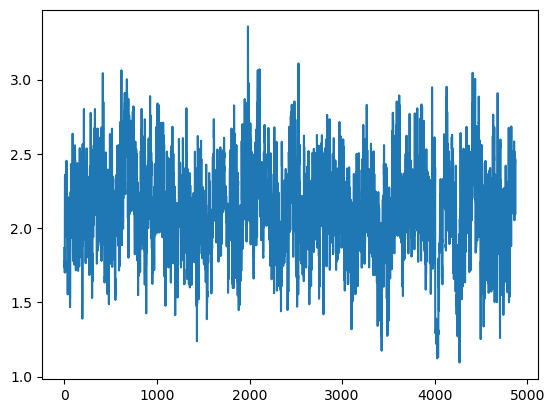

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4c0c1b1710>

In [13]:
plot(predictions)

In [ ]:
println(y_test[252])
println(y_marginal[252])

In [ ]:
#RMSE Correlation with Log Posterior
for j=9:10
    current_chain = j
    chain_scores = []
    chain_MSES = []
    chain_obs = obs
    chain_obs[:y] = y_test
    for i =1:length(traces[current_chain])
        current_trace = traces[current_chain][i]
        push!(chain_scores,get_score(current_trace))
        pred_y = transpose(G(x_test,current_trace))[:,1]
        current_mse = mse_scaled(pred_y, y_test)
        push!(chain_MSES,current_mse)
    end
    scatter(chain_MSES,chain_scores)
    #plot(chain_MSES)
end

In [ ]:
#Plot some hyperparameters
for j=1:chains
    chain = j
    taus = [1/traces[chain][i][:τᵧ] for i=1:length(traces[chain])]
    plot(taus)
end
plt.title("Gibbs Updates to Noise Variance")
plt.xlabel("Iteration")
plt.ylabel("Variance")
plt.ylim(0,0.5);

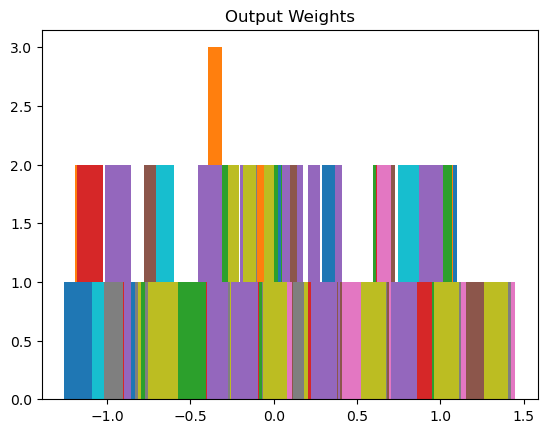

In [16]:
#Weights Dictionary
trace_number = 10
iter = 3
active_traces = traces[trace_number][iter:length(traces[trace_number])]
length(active_traces)
for trace in active_traces
    active_weights = []
    for j=1:length(trace[(:W,2)])
        push!(active_weights,trace[(:W,2)][j])
    end
    hist(active_weights)
end
plt.title("Output Weights");

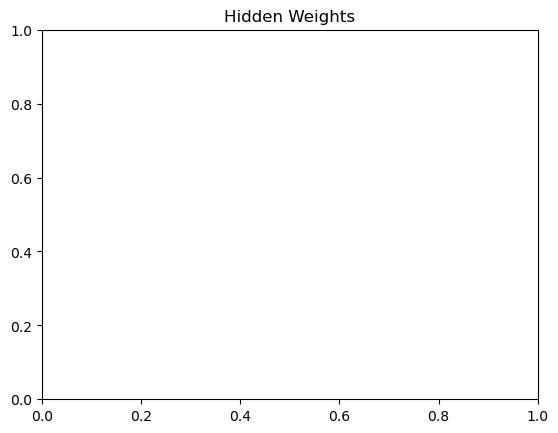

In [18]:
#Weights Dictionary
trace_number = 10
iter = 100
active_traces = traces[trace_number][iter:length(traces[trace_number])]
length(active_traces)
for trace in active_traces
    active_weights = []
    for j=1:length(trace[(:W,1)])
        push!(active_weights,trace[(:W,1)][j])
    end
    hist(active_weights)
end
plt.title("Hidden Weights");

In [19]:
println(traces[1][800][(:W,1)])

BoundsError: BoundsError: attempt to access 31-element Array{Any,1} at index [800]

In [ ]:
#Network hyperparameters
k_real = 2 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 8 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

#Hyperprior Hyperparameters
αᵧ = 1 #Regression Noise Shape
βᵧ = 1 #Regression Noise Scale/Rate
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape
β₂ = k_real; #Hidden & Output Weights Scale

#Bayesian Neural Network 

function G2(x, trace)
    activation = relu
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:l]
    
    for i=1:l
        in_dim, out_dim = layer_unpacker(i, l, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,l+1)], 1, ks[l])
    bₒ = reshape(trace[(:b,l+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
    
end;

#Probabilistic Model

@gen function interpolator(x)
    
    d = length(x[:,1])
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #####################################
    #New hyperparameter schedule - Mar 8#
    #####################################
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Noise Variance
    τᵧ ~ gamma(αᵧ,βᵧ)
    σᵧ = 1/τᵧ
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}    
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l])
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}  
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    
    #Regression Likelihood
    Sy = Diagonal([σᵧ for i=1:length(x[1,:])])::Diagonal{<:Real}
    y = @trace(mvnormal(vec(scores), Sy), (:y))

    return scores
    
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;